In [ ]:
!pip install transparent-background

In [7]:
#!pip install Pillow
#!pip install scipy
#!pip install matplotlib
#!pip install focal-loss

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls

Unet_2D.py  dataset  shadow_removal.ipynb


In [ ]:
import cv2
from PIL import Image
from transparent_background import Remover

remover = Remover()

input_path = '/content/881754813.jpg'
output_path = '/content/output3.png'

input = Image.open(input_path)
output = remover.process(input)
Image.fromarray(output).save(output_path)

In [ ]:
from rembg import remove
from PIL import Image

input_path = '/content/881754813.jpg'
output_path = '/content/output3.png'

input = Image.open(input_path)
output = remove(input)
output.save(output_path)

# Pre-Entrenamiento

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator


size = 400
batch_size = 4
seed = 123

path_trainX = '/dataset/pre-training/train/'
path_valX = '/dataset/pre-training/val/'


train_datagen = ImageDataGenerator(rescale=1/255,
                                rotation_range=90,
                                #width_shift_range=0.2,
                                #height_shift_range=0.2,
                                zoom_range=0.05,
                                horizontal_flip=True,)
                                #fill_mode='reflect')
## Train Dataset
trainX_generator = train_datagen.flow_from_directory(path_trainX,
                                                    seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = "input"
                                                    )

## Val Dataset
valX_generator = train_datagen.flow_from_directory(path_valX,
                                                  seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = "input"
                                                  )

KeyboardInterrupt: ignored

In [ ]:
from Unet_2D import build_model

input_shape = (size,size,3)
model = build_model(input_shape,3)

In [ ]:
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mse'],
              run_eagerly=None)


num_train_imgs = len(os.listdir(path_trainX+'productos/'))
steps_per_epoch_train = num_train_imgs // batch_size

num_val_imgs = len(os.listdir(path_valX+'productos/'))
steps_per_epoch_val = num_val_imgs // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Shadow_removal/shadow_removal_self_supervised_v2.hdf5',
                                   monitor='val_loss', save_best_only=True, save_weights_only=False)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.25,patience=5,min_lr=0.000001,cooldown=1,min_delta=0.0001)

history = model.fit(trainX_generator,
                    validation_data=valX_generator,
                    steps_per_epoch=steps_per_epoch_train,
                    validation_steps=steps_per_epoch_val,
                    epochs=30,
                    shuffle=True,
                    callbacks=[early_stopping,model_checkpoint,lr_scheduler])

Epoch 1/30
193/193 [==============================] - 768s 4s/step - loss: 0.1082 - mse: 0.1082 - val_loss: 0.1137 - val_mse: 0.1137 - lr: 1.0000e-05
Epoch 2/30
193/193 [==============================] - 274s 1s/step - loss: 0.0459 - mse: 0.0459 - val_loss: 0.0472 - val_mse: 0.0472 - lr: 1.0000e-05
Epoch 3/30
193/193 [==============================] - 285s 1s/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0184 - val_mse: 0.0184 - lr: 1.0000e-05
Epoch 4/30
193/193 [==============================] - 286s 1s/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0116 - val_mse: 0.0116 - lr: 1.0000e-05
Epoch 5/30
193/193 [==============================] - 274s 1s/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0081 - val_mse: 0.0081 - lr: 1.0000e-05
Epoch 6/30
193/193 [==============================] - 284s 1s/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0060 - val_mse: 0.0060 - lr: 1.0000e-05
Epoch 7/30
193/193 [==============================] - 284s 1s/step - loss: 0.0070 - mse: 0.0070 - va

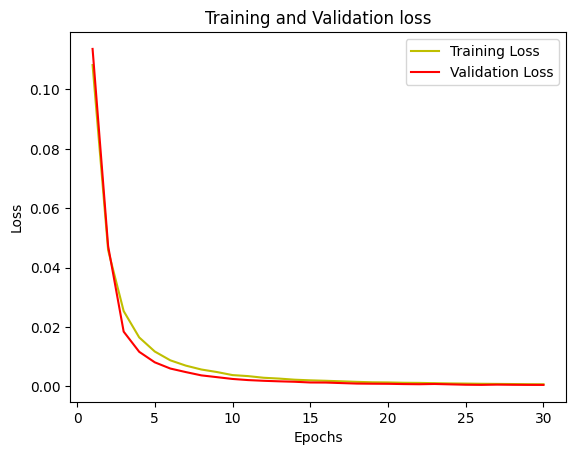

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pickle

with open('/content/drive/MyDrive/Shadow_removal/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Entrenamiento

In [13]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator


size = 400
batch_size = 2
seed = 123

path_trainX = 'dataset/train/input/train/'
path_trainY = 'dataset/train/target_mask/train/'
path_valX = 'dataset/train/input/val/'
path_valY = 'dataset/train/target_mask/val/'

train_datagen = ImageDataGenerator(rescale=1/255,
                                rotation_range=25,
                                #width_shift_range=0.2,
                                #height_shift_range=0.2,
                                zoom_range=0.02,
                                horizontal_flip=True,)
                                #fill_mode='reflect')
## Train Dataset
trainX_generator = train_datagen.flow_from_directory(path_trainX,
                                                    seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None
                                                    )
trainY_generator = train_datagen.flow_from_directory(path_trainY,
                                                    seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None,
                                                    color_mode='grayscale'
                                                    )
## Val Dataset
valX_generator = train_datagen.flow_from_directory(path_valX,
                                                  seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None
                                                )
valY_generator = train_datagen.flow_from_directory(path_valY,
                                                  seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None,
                                                   color_mode='grayscale'
                                                )

train_generator = zip(trainX_generator,trainY_generator)
val_generator = zip(valX_generator,valY_generator)

Found 736 images belonging to 1 classes.
Found 736 images belonging to 1 classes.
Found 146 images belonging to 1 classes.
Found 146 images belonging to 1 classes.


In [2]:
x = trainX_generator.next()
y = trainY_generator.next()

print(x.shape)
print(y.shape)

(6, 400, 400, 3)
(6, 400, 400, 1)


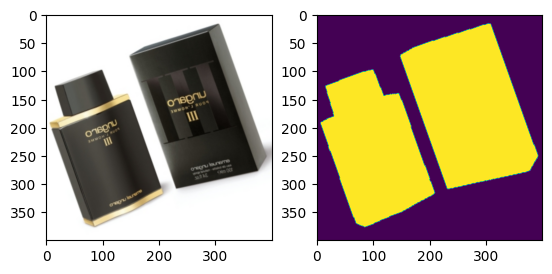

In [3]:
import matplotlib.pyplot as plt

x = trainX_generator.next()
y = trainY_generator.next()

for i in range(0,1):
  image_shadow = x[i]
  image_without_shadow = y[i]
  plt.subplot(1,2,1)
  plt.imshow(image_shadow)
  plt.subplot(1,2,2)
  plt.imshow(image_without_shadow)
  plt.show()


# Training

In [ ]:
from tensorflow.keras.models import load_model

premodel = load_model('/content/drive/MyDrive/Shadow_removal/shadow_removal_self_supervised_v2.hdf5', compile=False)


In [2]:
!nvidia-smi

Mon Dec 25 12:25:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.36                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070        On  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8              15W / 200W |    638MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [14]:
## Unet
from models.unet import unet_model

input_shape = (size,size,3)
model = unet_model(input_shape,'leaky_relu')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 400, 400, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 group_normalization_18 (Gr  (None, 400, 400, 64)         128       ['conv2d_19[0][0]']           
 oupNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 400, 400, 64)         0         ['group_normalization_18

In [8]:
## ResidualNet
from models.resUnet import residualunet

input_shape = (size,size,3)
model = residualunet(input_shape,dropout=0)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 400, 400, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_54 (Ba  (None, 400, 400, 64)         256       ['conv2d_54[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_54 (Activation)  (None, 400, 400, 64)         0         ['batch_normalization_54

In [6]:
num_train_imgs = len(os.listdir(path_trainX+'shadow/'))
steps_per_epoch_train = num_train_imgs // batch_size
steps_per_epoch_train

368

In [20]:
from keras.src.losses import BinaryCrossentropy
import os
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from focal_loss import BinaryFocalLoss

def IoU_metric(y_true, y_pred):
    #print("y_true shape:", y_true.shape)
    #print("y_pred shape:", y_pred.shape)
    y_true = K.flatten(y_true)
    y_pred = K.flatten(K.round(y_pred))  # Round the predicted values to 0 or 1

    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred) - intersection

    return (intersection + K.epsilon()) / (union + K.epsilon())
def IoU_loss(y_true, y_pred):
  return -IoU_metric(y_true,y_pred)

def DiceLoss(y_true, y_pred, smooth=1e-5):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    intersection = K.sum(y_true * y_pred)
    dice = (2 * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1 - dice

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_learning_rate = self.model.optimizer.learning_rate.numpy()
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Learning Rate: {current_learning_rate:.5f}")

        # Print other metrics and losses
        for name, value in logs.items():
            print(f"{name}: {value:.4f}", end=" | ")

In [ ]:
## Steps 
epochs = 100
num_train_imgs = len(os.listdir(path_trainX+'shadow/'))
steps_per_epoch_train = num_train_imgs // batch_size

num_val_imgs = len(os.listdir(path_valX+'shadow/'))
steps_per_epoch_val = num_val_imgs // batch_size


cosine_decay_scheduler = CosineDecay(1e-4, 0.7, alpha=0.1,
                                    warmup_target=1e-4,
                                    warmup_steps=steps_per_epoch_train*epochs*0.2)

opt = Adam(learning_rate=cosine_decay_scheduler)
model.compile(optimizer=opt,
              #loss=BinaryFocalLoss(gamma=1.7),
              loss=DiceLoss,
              metrics=[IoU_metric],
              run_eagerly=True)

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('trained_models/shadow_removal_Unet_diceloss.keras',
                                   monitor='val_loss', save_best_only=True, save_weights_only=False)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=steps_per_epoch_train,
                    validation_steps=steps_per_epoch_val,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=[model_checkpoint, CustomCallback()])

Epoch 1/100
368/368 [==============================] - ETA: 0s - loss: 0.0349 - IoU_metric: 0.9356
Epoch 1/100
Learning Rate: 0.00010
368/368 [==============================] - 99s 260ms/step - loss: 0.0349 - IoU_metric: 0.9356 - val_loss: 0.0308 - val_IoU_metric: 0.9428
Epoch 2/100
368/368 [==============================] - ETA: 0s - loss: 0.0299 - IoU_metric: 0.9441
Epoch 2/100
Learning Rate: 0.00010
368/368 [==============================] - 96s 260ms/step - loss: 0.0299 - IoU_metric: 0.9441 - val_loss: 0.0258 - val_IoU_metric: 0.9512
Epoch 3/100
368/368 [==============================] - ETA: 0s - loss: 0.0289 - IoU_metric: 0.9457
Epoch 3/100
Learning Rate: 0.00010
368/368 [==============================] - 96s 261ms/step - loss: 0.0289 - IoU_metric: 0.9457 - val_loss: 0.0345 - val_IoU_metric: 0.9353
Epoch 4/100
368/368 [==============================] - ETA: 0s - loss: 0.0276 - IoU_metric: 0.9479
Epoch 4/100
Learning Rate: 0.00010
368/368 [==============================] - 96s 260

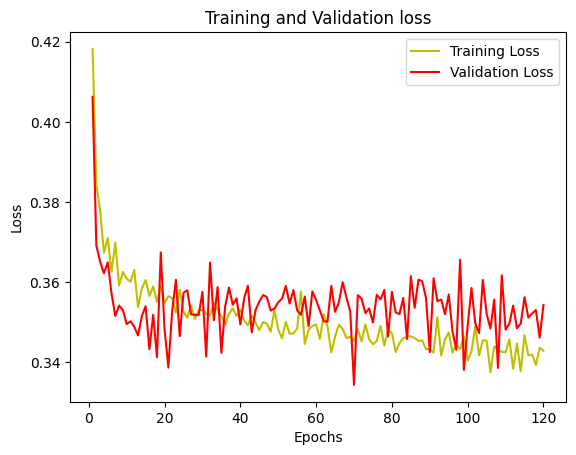

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing

In [ ]:
import tensorflow as tf
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Shadow_removal/shadow_removal.hdf5',compile=False)

OSError: ignored

In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

seed = 123
size = 400
batch_size = 8
path_testX = '/content/drive/MyDrive/Shadow_removal/input/test/'
path_testY = '/content/drive/MyDrive/Shadow_removal/target_mask/test/'

test_datagen = ImageDataGenerator(rescale=1/255,)

testX_generator = test_datagen.flow_from_directory(path_testX,
                                                  seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None
                                                )
testY_generator = test_datagen.flow_from_directory(path_testY,
                                                  seed=seed,
                                                    target_size = (size,size),
                                                    batch_size = batch_size,
                                                    class_mode = None
                                                )

test_generator = zip(testX_generator,testY_generator)

Found 110 images belonging to 1 classes.
Found 110 images belonging to 1 classes.


In [ ]:
num_test_imgs = len(os.listdir(path_testX+'shadow/'))
steps_per_epoch_test = num_train_imgs // batch_size

evaluation = model.evaluate(test_generator)

InvalidArgumentError: ignored

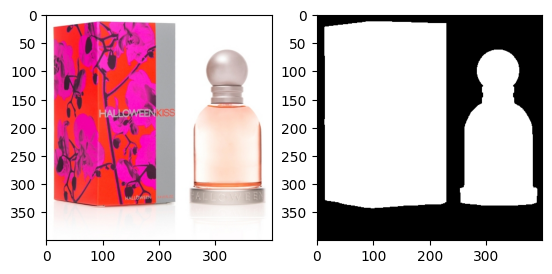

In [41]:
import matplotlib.pyplot as plt

x = testX_generator.next()
y = testY_generator.next()

for i in range(0,1):
  image_shadow = x[i]
  image_without_shadow = y[i]
  plt.subplot(1,2,1)
  plt.imshow(image_shadow)
  plt.subplot(1,2,2)
  plt.imshow(image_without_shadow)
  plt.show()


In [48]:
import random
import numpy as np

test_img_number = random.randint(0,x.shape[0]-1)
test_img = x[test_img_number]
ground_truth = y[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_masks =  (prediction >= 0.5).astype(np.uint8)

1/1 [==============================] - 0s 57ms/step


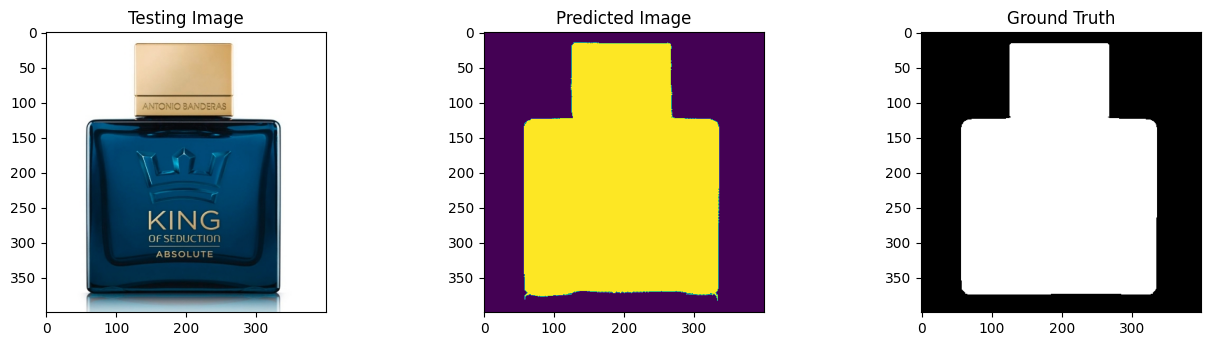

In [49]:

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Predicted Image')
plt.imshow(predicted_masks[0])
plt.subplot(233)
plt.title('Ground Truth')
plt.imshow(ground_truth)

plt.show()


NameError: ignored

In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum((y_true + y_pred) > 0)
    iou = intersection / union   # Adding a small epsilon to avoid division by zero
    return iou

# Calculate IoU for each pair of true and predicted masks
iou_scores = [calculate_iou(true_mask, pred_mask) for true_mask, pred_mask in zip(testY_generator, predicted_masks)]

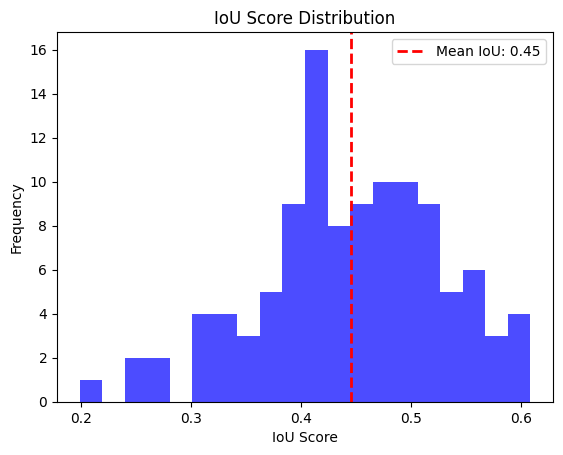

In [ ]:
import matplotlib.pyplot as plt

# Create a histogram/distribution plot of IoU scores
plt.hist(iou_scores, bins=20, color='blue', alpha=0.7)
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.title('IoU Score Distribution')

# Calculate and display the mean IoU
mean_iou = np.mean(iou_scores)
plt.axvline(mean_iou, color='red', linestyle='dashed', linewidth=2, label=f'Mean IoU: {mean_iou:.2f}')
plt.legend()

# Show the plot
plt.show()

In [ ]:
iou_threshold = 0.3
low_iou_indices = [i for i, iou in enumerate(iou_scores) if iou < iou_threshold]

In [ ]:
for idx in low_iou_indices:
    true_mask = testY_generator[idx]
    predicted_mask = predicted_masks[idx]
    original_image = testX_generator[idx]  # Replace with your actual original images

    # Create a subplot for each mask
    plt.figure(figsize=(12, 4))

    # Plot the original image (if available)
    if original_image is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title('Original Image')

    # Plot the true label mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Label Mask')

    # Plot the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.show()
    break

ValueError: ignored